## Mathematical aspects of Machine Learning: exercise sheet 2 

Lecturers: Péter Koltai, Mattes Mollenhauer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

def perceptron_learning(data,labels,extended = True, max_iter=10**5):
    '''
    
    Perceptron learning algorithm for binary {+/- 1} labeled data. Terminates automatically, if the data is separated
    linearly, else runs for a maximum number of iterations and returns last stored iterate of (almost) separating
    hyperplane or separating hyperplane classifying the biggest number of points correctly (pocket algorithm).
    
    Inputs:
        data: 2d numpy array
        labels: {+1,-1} list/array classifying each data row
        max_iter: maximal number of iterations
        
    Outputs:
        w: weight vector in extended feature space defining separating hyperplane
        iterate_count: number of iterations needed until termination (an iteration is a modification of w)
        log: list number of correctly classified data rows in each iteration step
    '''
    iterate_count = 0
    active_label = 0
    n_correct = 0
    log = [0] #initial "correctly classified" log entry 
    n = data.shape[0]
    
    if extended:
        # embed data into extended n+1 dimensional feature space
        data = np.c_[ data, np.ones(data.shape[0]) ]
    
    # weight vector initialization
    w = np.random.rand(data.shape[1])*10
    
    #weight update iteration
    while True:
        
        #break condition
        if n_correct >= n or iterate_count >= max_iter:
            log.append(n_correct);
            break;
        
        #choosing next data point
        x = data[int(active_label)];
        
        #add/subtract weight modification routine
        if np.dot(x,w) <= 0 and labels[active_label] > 0:
            w = w + x
            log.append(n_correct)
            iterate_count += 1
            active_label = 0
            n_correct = 0
        elif np.dot(x,w) >= 0 and labels[active_label] < 0:
            w = w - x
            log.append(n_correct)
            iterate_count += 1
            active_label = 0
        else:
            active_label += 1
            n_correct += 1
        
    return w,iterate_count,log[1:]   

## Exercise 1b

We generate the data by randomly sampling points, a weight vector and a bias and then distributing labels according to the resulting hyperplane. 

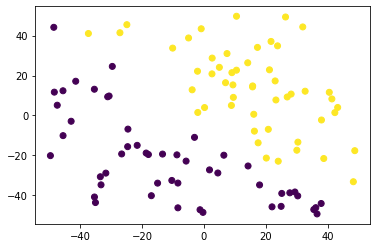

In [3]:
def generate(n=2 ,l=100):
    '''
    generates stricly linearly separable data and corresponding {+/- 1} labels
    of length n and dimension l
    '''
    data = 100 * np.random.rand(l, n) - np.ones((l, n)) * 50
    
    w = 10 * np.random.rand(n, 1)
    bias = 30 * np.random.rand(1)
    labels = np.zeros(l, dtype=np.int8)
    for i,d in enumerate(data):
        if np.dot(d, w) + bias > 0:
            labels[i] = 1
        elif np.dot(d,w) + bias < 0:
            labels[i] = -1
        else:
            generate(n,l) #if not strictly separable, try again
    return data,labels


data,labels = generate()
plt.scatter(data[:,0],data[:,1],c=labels)

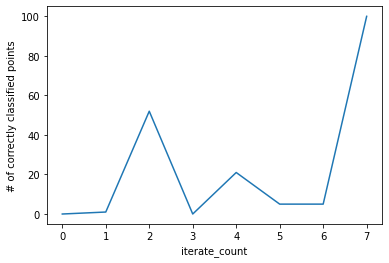

Iterations: 7


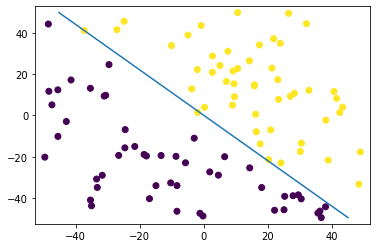

In [4]:
# test perceptron algorithm
w, iter_count, log = perceptron_learning(data, labels, max_iter=10**5)
plt.plot(np.arange(np.shape(log)[0]),log)
plt.xlabel('iterate_count')
plt.ylabel('# of correctly classified points')
plt.show()
print('Iterations: {}'.format(iter_count))

# visualize the hyperplane
from sympy import symbols
from sympy.solvers.solveset import linsolve
from sympy import plot,solve
x, y = symbols('x, y')
solution = solve([w[0]*x+w[1]*y+w[2]], (x, y))
solfunc = solution[x]
eval_vec = np.linspace(np.min(data[:,1]),np.max(data[:,1]),10)
solutions = [solfunc.subs(y,i) for i in eval_vec]
plt.plot(solutions,eval_vec)
plt.scatter(data[:,0],data[:,1],c=labels)
plt.xlim((np.min(data[:,0]-3),np.max(data[:,0]+3)))
plt.ylim((np.min(data[:,1]-3),np.max(data[:,1]+3)))
plt.show()

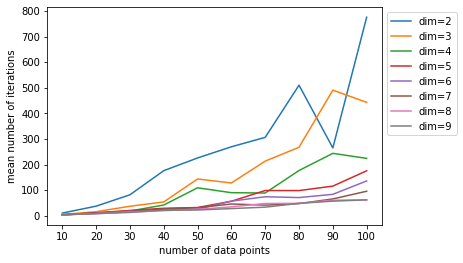

In [5]:
N = 100
N_dim = 10
iter_trials = np.zeros(N)
n_data_vec = np.arange(10, 101, 10)
iter_statistic = np.zeros([N_dim - 2, np.size(n_data_vec)])

for n_dim in range(2,N_dim):
    for n_data in range(np.size(n_data_vec)):
        l = n_data_vec[n_data]
        for n_trials in range(N):
            data,labels = generate(n_dim, l)
            w, iter_trials[n_trials], log = perceptron_learning(data,labels, max_iter=10**5)
        iter_statistic[n_dim - 2, n_data] = np.mean(iter_trials)

plt.plot(np.transpose(iter_statistic))
plt.legend(['dim=2','dim=3','dim=4','dim=5','dim=6','dim=7','dim=8','dim=9'], bbox_to_anchor=(1, 1), loc=2)
plt.ylabel('mean number of iterations')
plt.xlabel('number of data points')
ticks = plt.xticks(range(0, 10), range(10, 101, 10))

## Exercise 1c

The idea is to generate data which leads to very instable behaviour - for example by choosing a layout such that the weight vector needs to be found within a very small margin of error. See below:

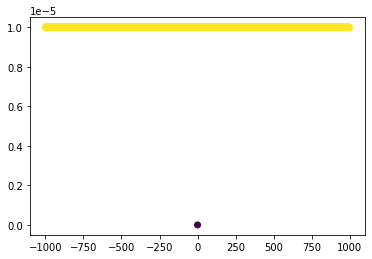

In [6]:
bad_data = np.append(np.array([[i, 1*.00001] for i in range(-1001, 1001)]), [[0, 0]] , axis=0)
bad_labels = np.append(np.array([True for i in range(-1001, 1001)]),[False], axis=0)
plt.scatter(bad_data[:,0], bad_data[:,1], c=bad_labels)

In [7]:
w,n_iter,log = perceptron_learning(bad_data, bad_labels, extended=True, max_iter=10**5)
print(n_iter)

2820


## Exercise 1d

The idea here is to sample points from the Gaussian and assign a **single** class to them (say "True"). If the perceptron algorithm **without** extended state space does not converge with respect to a fixed number of iterations, we consider the data not to be on a common (hyper)-halfplane.

Repeat the experiment in Monte Carlo fashion to sample the probability that the data is on a common (hyper)-halfplane.

In [8]:
from numpy.random import multivariate_normal

In [9]:
def mc_perceptron(n_points, dim, trials, max_iter=100):
    """
    Samples the probability that for
    n_points (int) independent copies of 
    the dim (int)-dimensional random varable X ~ N( 0, Id)
    lie on a common hyperplane.
    
    The simulation is run n_trials (int) times.
    """
    
    mean = np.zeros(dim)
    cov = np.eye(dim)
    trial_vec = []
    labels = np.array([True for i in range(n_points)])
    
    for i in range(n_trials): # monte carlo iteration
        data = multivariate_normal(mean, cov, n_points) # sampling
        _, n_iter, _ = perceptron_learning(data, labels, extended=False, max_iter=max_iter)
        terminated = not (max_iter == n_iter)
        trial_vec.append(terminated)
    return sum(trial_vec) / n_trials
    

In [10]:
mc_perceptron(4, 3, 10000, 100)

0.8282828282828283